In [81]:
import pandas as pd
from stellargraph import StellarGraph

base_path = "/home/colombelli/Documents/datasets/acgt/kidney/stellargraph/"
edges_file = base_path+"patients_edges.csv"
features_file = base_path+"patients_features.csv"
classes_file = base_path+"patients_classes.csv"

In [82]:
# Imports required for following the tutorial: 
# https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gat-node-classification.html

import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
# Loading data and building the StellarGraph object

df_patients = pd.read_csv(edges_file)
df_features = pd.read_csv(features_file, index_col=0)
df_classes = pd.read_csv(classes_file, index_col=0).sample(frac=1)

In [84]:
G = StellarGraph(edges=df_patients, nodes=df_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 541, Edges: 35711

 Node types:
  default: [541]
    Features: float32 vector, length 10000
    Edge types: default-default->default

 Edge types:
    default-default->default: [35711]
        Weights: range=[0.960001, 0.99577], mean=0.967045, std=0.00527737
        Features: none


In [85]:
# Splitting data into train/validation/test

train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

series_classes = df_classes['class']

train_subjects, test_subjects = model_selection.train_test_split(
    series_classes, test_size=1-train_ratio, stratify=series_classes)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, test_size=test_ratio/(test_ratio + validation_ratio), stratify=test_subjects)

print("Len train: ", len(train_subjects))
print("Len validation: ", len(val_subjects))
print("Len test: ", len(test_subjects))
print("\nLen everything: ", len(val_subjects)+len(test_subjects)+len(train_subjects))

Len train:  405
Len validation:  81
Len test:  55

Len everything:  541


In [86]:
from collections import Counter
Counter(train_subjects)

Counter({'stage1': 181,
         'stage3': 82,
         'stage2': 37,
         'control': 53,
         'stage4': 52})

In [87]:
# Converting to one-hot encoding

target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [88]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)

In [89]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["elu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

x_inp, predictions = gat.in_out_tensors()

In [90]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

val_gen = generator.flow(val_subjects.index, val_targets)

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
    
es_callback = EarlyStopping(
    monitor="val_acc", patience=200
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [92]:
history = model.fit(
    train_gen,
    epochs=500,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/500
1/1 - 3s - loss: 7.6822 - acc: 0.3309 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 2/500
1/1 - 0s - loss: 9.5950 - acc: 0.3259 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 3/500
1/1 - 0s - loss: 11.2915 - acc: 0.2321 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 4/500
1/1 - 0s - loss: 12.4592 - acc: 0.1951 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 5/500
1/1 - 0s - loss: 12.6347 - acc: 0.1975 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 6/500
1/1 - 0s - loss: 12.1963 - acc: 0.2173 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 7/500
1/1 - 1s - loss: 12.3897 - acc: 0.2148 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 8/500
1/1 - 0s - loss: 13.0177 - acc: 0.1852 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 9/500
1/1 - 0s - loss: 12.1641 - acc: 0.1975 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 10/500
1/1 - 0s - loss: 12.1184 - acc: 0.2370 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 11/500
1/1 - 0s - loss: 9.7078 - acc: 0.3580 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 12/500
1/1 - 0s - loss: 11.

Epoch 94/500
1/1 - 0s - loss: 10.8317 - acc: 0.3111 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 95/500
1/1 - 0s - loss: 10.3825 - acc: 0.3235 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 96/500
1/1 - 0s - loss: 11.5380 - acc: 0.2691 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 97/500
1/1 - 0s - loss: 11.0401 - acc: 0.3086 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 98/500
1/1 - 0s - loss: 11.1796 - acc: 0.2889 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 99/500
1/1 - 0s - loss: 9.7983 - acc: 0.3630 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 100/500
1/1 - 0s - loss: 12.0314 - acc: 0.2074 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 101/500
1/1 - 0s - loss: 8.6669 - acc: 0.3926 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 102/500
1/1 - 0s - loss: 10.3439 - acc: 0.3284 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 103/500
1/1 - 0s - loss: 11.1267 - acc: 0.3037 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 104/500
1/1 - 0s - loss: 9.3892 - acc: 0.3802 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 105/500
1/1 -

Epoch 186/500
1/1 - 0s - loss: 10.6698 - acc: 0.3284 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 187/500
1/1 - 0s - loss: 12.1691 - acc: 0.2346 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 188/500
1/1 - 0s - loss: 9.1565 - acc: 0.4049 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 189/500
1/1 - 0s - loss: 11.8427 - acc: 0.2296 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 190/500
1/1 - 0s - loss: 9.7232 - acc: 0.3654 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 191/500
1/1 - 0s - loss: 9.7456 - acc: 0.3802 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 192/500
1/1 - 0s - loss: 8.3564 - acc: 0.3926 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 193/500
1/1 - 0s - loss: 10.2803 - acc: 0.3210 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 194/500
1/1 - 0s - loss: 9.4543 - acc: 0.3852 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 195/500
1/1 - 0s - loss: 11.4010 - acc: 0.2765 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 196/500
1/1 - 0s - loss: 11.1990 - acc: 0.2914 - val_loss: 8.9545 - val_acc: 0.4444
Epoch 197/500
1

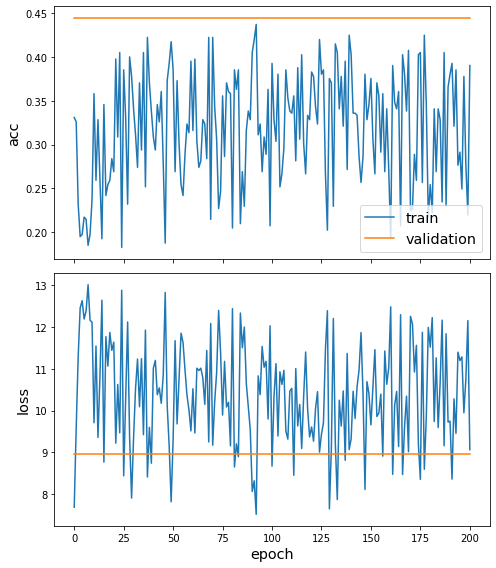

In [93]:
sg.utils.plot_history(history)

In [94]:
model.load_weights("logs/best_model.h5")
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 74ms/step - loss: 8.7917 - acc: 0.4545

Test Set Metrics:
	loss: 8.7917
	acc: 0.4545


In [95]:
all_nodes = series_classes.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [96]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": series_classes})
df['Predicted'].value_counts()

stage1    541
Name: Predicted, dtype: int64

In [97]:
G.check_graph_for_ml()

In [98]:
for component in G.connected_components():
    print(len(component))

530
3
2
2
2
2


In [99]:
G.node_degrees()

defaultdict(int,
            {'TCGA.3Z.A93Z.01': 171,
             'TCGA.A3.3306.01': 8,
             'TCGA.A3.3307.01': 281,
             'TCGA.A3.3308.01': 132,
             'TCGA.A3.3311.01': 302,
             'TCGA.A3.3316.01': 54,
             'TCGA.A3.3317.01': 50,
             'TCGA.A3.3319.01': 1,
             'TCGA.A3.3320.01': 206,
             'TCGA.A3.3322.01': 221,
             'TCGA.A3.3323.01': 156,
             'TCGA.A3.3324.01': 249,
             'TCGA.A3.3325.01': 262,
             'TCGA.A3.3326.01': 225,
             'TCGA.A3.3329.01': 262,
             'TCGA.A3.3331.01': 256,
             'TCGA.A3.3335.01': 18,
             'TCGA.A3.3343.01': 243,
             'TCGA.A3.3347.01': 31,
             'TCGA.A3.3349.01': 250,
             'TCGA.A3.3351.01': 182,
             'TCGA.A3.3352.01': 206,
             'TCGA.A3.3357.01': 51,
             'TCGA.A3.3358.11': 42,
             'TCGA.A3.3358.01': 277,
             'TCGA.A3.3359.01': 246,
             'TCGA.A3.3362.01':

## Correlation distribution among patients

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

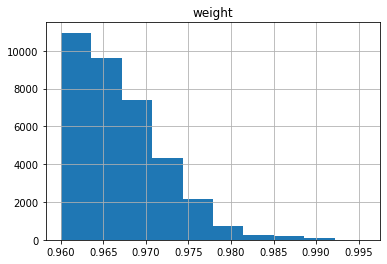

In [100]:
df_patients.hist(column='weight')

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

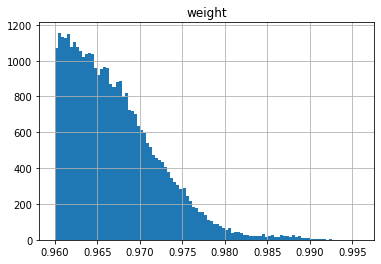

In [101]:
df_patients.hist(column='weight', bins=100)

<AxesSubplot:ylabel='Density'>

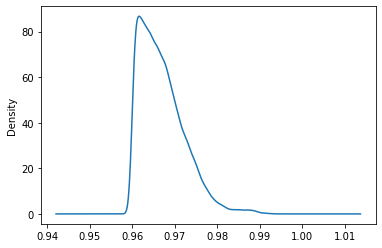

In [102]:
df_patients['weight'].plot.kde()